<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab8.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 8: GANs

### Description
In this lab, we will build our very first GAN. This can be frustrating at first, but the end result is really cool. We've tried to make the steps intuitive.

Here is what you will learn:
* GANs are generative models that learn to generate data, based on a min-max/adversarial game between a Generator (G) and Discriminator (D).
* The parameters of both Generator and Discriminator are optimized with Stochastic Gradient Descent (SGD) or RMSprop or Adam
* How these concepts translate into PyTorch code for GAN optimization.

Overview of the tutorial:
1. GAN intro
2. Defining the neural networks in PyTorch, computing a forward pass
3. Training our GAN

This lab is modified from https://github.com/tomsercu/gan-tutorial-pytorch

### Deliverable
We have provided the GAN architecture for you. Your objective is to:
1. Create a DataLoader for the CelebA dataset.
2. Create a Dataset and a DataLoader for a dataset from a domain of your choice.
3. Implement the original GAN loss
4. Implement the training loop and train your GAN.

### Grading Standards
- 25% correctly implement the original GAN loss
- 25% correctly implement the training loop 
- 25% Train on CelebA and display results
- 25% Train on your own dataset and display results

(you will not be graded on quality of generated images)


### Tips:
- This lab is complex. Please read through the entire spec before diving in.
- Also, note that training on this dataset will likely take some time. Please make sure you start early enough to run the training long enough!
- Expected values: Discriminator Loss will hover around ~ 0.5, Generator Loss should hover around ~ 5.5. You should see discernible results within 1 epoch (~20-30 minutes of training on Colab).

# Some cool demos:
* Progress over the last 5 years, from [Ian Goodfellow tweet](https://twitter.com/goodfellow_ian/status/1084973596236144640)

![tweet image](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/goodfellow_tweet.jpg?raw=1)

* CycleGAN translating horses into zebras: https://www.youtube.com/watch?v=9reHvktowLY
* CycleGAN teaser: ![cyclegan teaser image](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/cyclegan_teaser_high_res.jpg?raw=1)
* High resolution faces with StyleGAN https://www.youtube.com/watch?v=kSLJriaOumA
* https://ganbreeder.app web-interface to create images based on [BigGan](https://arxiv.org/abs/1809.11096)


# 1. GAN first introduction
[GAN picture](figs/gan_xavigiro.png)

<img src="https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/gan_xavigiro.png?raw=1" alt="GAN picture" style="width: 700px;"/>

GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

Let's start with defining the generator G and discriminator D in pytorch.

# 2. Define the Generator and Discriminator

In [10]:
import sys
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, time

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# You can use whatever display function you want. This is a really simple one that makes decent visualizations
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

## Defining the neural networks

In [2]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

In [3]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

In [4]:
#####
# instantiate a Generator and Discriminator according to their class definition.
#####
D = Discriminator()
G = Generator()
print(D)
print(G)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)
Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, m

## Testing the neural networks (forward pass)

In [5]:
samples = torch.randn(10, 3, 64, 64) # batch size x channels x width x height
D(samples)
print(D(samples).shape)

torch.Size([10, 1, 1, 1])


Things to try:
* What happens if you change the number of samples in a batch?
* What happens if you change the width/height of the input?
* What are the weights of the discriminator? You can get an iterator over them with `.parameters()` and `.named_parameters()`

In [6]:
for name, p in D.named_parameters():
    print(name, p.shape)

conv1.weight torch.Size([128, 3, 4, 4])
conv1.bias torch.Size([128])
conv2.weight torch.Size([256, 128, 4, 4])
conv2.bias torch.Size([256])
conv2_bn.weight torch.Size([256])
conv2_bn.bias torch.Size([256])
conv3.weight torch.Size([512, 256, 4, 4])
conv3.bias torch.Size([512])
conv3_bn.weight torch.Size([512])
conv3_bn.bias torch.Size([512])
conv4.weight torch.Size([1024, 512, 4, 4])
conv4.bias torch.Size([1024])
conv4_bn.weight torch.Size([1024])
conv4_bn.bias torch.Size([1024])
conv5.weight torch.Size([1, 1024, 4, 4])
conv5.bias torch.Size([1])


We will think of the concatentation of all these discriminator weights in one big vector as $\theta_D$.

Similarly we name the concatentation of all the generator weights in one big vector $\theta_G$.

In [7]:
for name, p in G.named_parameters():
    print(name, p.shape)

deconv1.weight torch.Size([100, 1024, 4, 4])
deconv1.bias torch.Size([1024])
deconv1_bn.weight torch.Size([1024])
deconv1_bn.bias torch.Size([1024])
deconv2.weight torch.Size([1024, 512, 4, 4])
deconv2.bias torch.Size([512])
deconv2_bn.weight torch.Size([512])
deconv2_bn.bias torch.Size([512])
deconv3.weight torch.Size([512, 256, 4, 4])
deconv3.bias torch.Size([256])
deconv3_bn.weight torch.Size([256])
deconv3_bn.bias torch.Size([256])
deconv4.weight torch.Size([256, 128, 4, 4])
deconv4.bias torch.Size([128])
deconv4_bn.weight torch.Size([128])
deconv4_bn.bias torch.Size([128])
deconv5.weight torch.Size([128, 3, 4, 4])
deconv5.bias torch.Size([3])


In [8]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 100).view(-1,100,1,1)
x_gen = G(z)
#notice that the generated value is a batch of 2 images
x_gen.shape

torch.Size([2, 3, 64, 64])

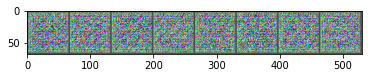

In [9]:
z = torch.randn(8, 100).view(-1,100,1,1).cuda()
G = G.cuda()
show_imgs(G(z))

In traditional deep learning, you measure performance by looking at the loss value. In GANs, this does not work well because we are performing a Min-Max and the loss values may not be intuitively lower when the network is doing well. 

So, performance must be measured qualitatively, by looking at images. Therefore, you can sample random $z$ vectors every pass through the network to see how "novel" the generation is becoming. And you can also sample a single $z$ vector that is passed through the network every time to see how a single example progresses during training. 

In [10]:
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = fixed_z_.cuda()

## Loading the data and computing forward pass

In [11]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')
#load and extract the zip file
!unzip '/content/drive/MyDrive/CS474/Project8/celeba.zip' -d '/content/images/'

Streaming output truncated to the last 5000 lines.
 extracting: /content/images/img_align_celeba/197600.jpg  
 extracting: /content/images/img_align_celeba/197601.jpg  
 extracting: /content/images/img_align_celeba/197602.jpg  
 extracting: /content/images/img_align_celeba/197603.jpg  
 extracting: /content/images/img_align_celeba/197604.jpg  
 extracting: /content/images/img_align_celeba/197605.jpg  
 extracting: /content/images/img_align_celeba/197606.jpg  
 extracting: /content/images/img_align_celeba/197607.jpg  
 extracting: /content/images/img_align_celeba/197608.jpg  
 extracting: /content/images/img_align_celeba/197609.jpg  
 extracting: /content/images/img_align_celeba/197610.jpg  
 extracting: /content/images/img_align_celeba/197611.jpg  
 extracting: /content/images/img_align_celeba/197612.jpg  
 extracting: /content/images/img_align_celeba/197613.jpg  
 extracting: /content/images/img_align_celeba/197614.jpg  
 extracting: /content/images/img_align_celeba/197615.jpg  
 extr

In [39]:
batch_size = 128
lr = 0.0002
train_epoch = 3

img_size = 64

#download the data, and change the filepath

# possible sources for celeba: this AWS link: https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
celeba_dataset = datasets.ImageFolder(root='/content/images/',
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
#get a subset of the data to fit the batch size, this will avoid the error thrown in the last iteration
n = batch_size * (len(celeba_dataset)//batch_size)
celeba_dataset = torch.utils.data.Subset(celeba_dataset, np.random.choice(np.arange(0,len(celeba_dataset),1,dtype=int), size = n))
##### Create the dataloader #####
celeba_train_loader = torch.utils.data.DataLoader(celeba_dataset, batch_size=batch_size)


Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at a sample:

torch.Size([3, 64, 64])


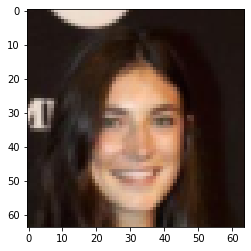

In [42]:
ix=140
x, _ = celeba_dataset[ix]
print(x.shape)
show_imgs(x)

Feed the image into the discriminator; the output will be the probability the (untrained) discriminator assigns to this sample being real.

In [43]:
# for one image:
Dscore = D(x.unsqueeze(0))
Dscore

tensor([[[[0.6380]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
# How you can get a batch of images from the dataloader:
xbatch, _ = iter(celeba_train_loader).next()
print(xbatch.shape)
D(xbatch)
D(xbatch).shape

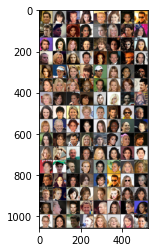

In [16]:
show_imgs(xbatch)

# 3. Now to train your GAN

We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. 

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.

BCE takes care of the log, you won't manually compute any Log values


In [11]:
def train(train_loader):
    num_iter = 0
    sig = nn.Sigmoid()
    for epoch in range(train_epoch):
        D_losses = []
        G_losses = []
        epoch_start_time = time.time()
        for x_, _ in tqdm(train_loader):
            # train discriminator D
            D_optimizer.zero_grad()

            mini_batch = x_.size()[0]

            #####
            # create y_real_ and y_fake_ tensors you will use in your BCE loss to push probabilities 
            # in the proper direction
            # y_real_ will be a tensor of all ones, because you want whatever is outputted by the generator
            # to be more likely to be real and you want the discriminator to recognize real images
            # y_fake_ then is a tensor of all zeros, because you want the discriminator to recognize fake images
            #####

            y_real_ = torch.ones(mini_batch,1)
            y_fake_ = torch.zeros(mini_batch,1)
            x_, y_real_, y_fake_ = x_.cuda(), y_real_.cuda(), y_fake_.cuda()

            #####
            # pass x_ through the discriminator to get D_result
            # you will need to squeeze() the output before passing it to BCE_loss
            # compute D_real_loss using BCE_loss and the proper y tensor from above
            # you are trying to make the discriminator recognize the real image properly
            #####
            D_result = torch.squeeze(torch.squeeze(D(x_),dim=1), dim=1)
            D_real_loss = BCE_loss(D_result,y_real_)

            #####
            # sample a z vector (remember to view(-1,100,1,1))
            # pass the z vector to the GPU and through your generator
            # this will create G_result
            #####
            z_vector = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)    # fixed noise
            z_vector = z_vector.cuda()
            G_result = G(z_vector)
            

            #####
            # pass G_result through the discriminator and get D_result
            # you will need to squeeze() the output of the discriminator
            # compute D_fake_loss for the generated images by using BCE_loss and the proper y_tensor
            # you are trying to make the discriminator recognize the fake image properly
            #####
            D_result = torch.squeeze(torch.squeeze(D(G_result),dim=1), dim=1)
            D_fake_loss = BCE_loss(D_result,y_fake_)

            #####
            # sum D_real_loss and D_fake_loss to get D_train_loss
            # compute the gradients
            # step the optimizer
            #####
            D_train_loss = D_real_loss + D_fake_loss
            D_train_loss.backward()
            D_optimizer.step()
            D_losses.append(D_train_loss.item())

            # train generator G
            G_optimizer.zero_grad()

            #####
            # sample a z vector (viewed properly) and pass it to the GPU and through the generator
            # compute the discriminated value of the generated image, properly squeezing the output
            # get G_train_loss by using BCE_loss and the proper y_tensor
            # you are trying to make the generator generate real images
            # compute the gradients
            # step the optimizer
            #####
            z_vector = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)    # fixed noise
            z_vector = z_vector.cuda()
            G_result = G(z_vector)
            D_result = torch.squeeze(torch.squeeze(D(G_result),dim=1), dim=1)
            G_train_loss = BCE_loss(D_result,y_real_)
            G_train_loss.backward()
            G_losses.append(G_train_loss.item())
            G_optimizer.step()

            num_iter += 1

        # generate a fixed_z_ image and save
        x_gen = G(fixed_z_)
        collect_x_gen.append(x_gen.detach().clone())
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        # print out statistics
        print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                                  torch.mean(torch.FloatTensor(G_losses))))
        show_imgs(G_result[:4])

  0%|          | 0/1582 [00:00<?, ?it/s]

[1/3] - ptime: 887.16, loss_d: 0.892, loss_g: 3.829


  0%|          | 0/1582 [00:00<?, ?it/s]

[2/3] - ptime: 881.33, loss_d: 0.640, loss_g: 3.698


100%|██████████| 1582/1582 [14:36<00:00,  1.80it/s]


[3/3] - ptime: 876.69, loss_d: 0.512, loss_g: 4.065


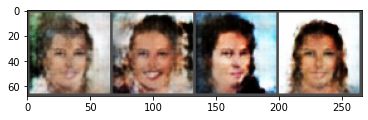

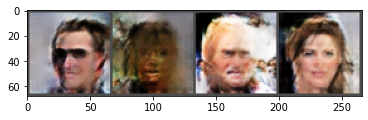

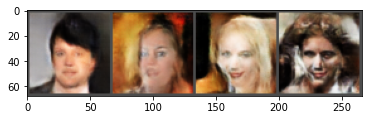

In [18]:
G = Generator(128)
D = Discriminator(128)
G = G.cuda()
D = D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Train GAN
collect_x_gen = []
train(celeba_train_loader)

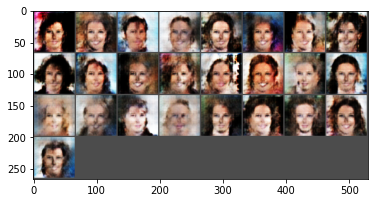

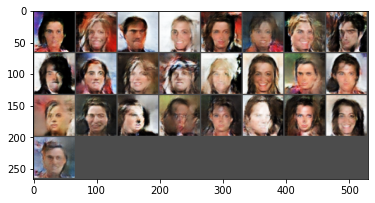

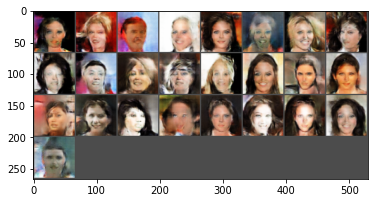

In [20]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

Now generate something with your own dataset! (Fashion, Mnist, Coco, Bedrooms, Pokemon)

In [19]:
# Create a Dataloader for your own dataset
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = fixed_z_.cuda()
my_batch_size = 200
img_size = 64
lr = 0.0002
train_epoch = 3
mnist_dataset =   torchvision.datasets.CIFAR10('/content/torch_mnist', train=True, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                             ]))
print(len(mnist_dataset))
#get a subset that has the right batch sizes
n = my_batch_size * (len(mnist_dataset)//my_batch_size)
mnist_dataset = torch.utils.data.Subset(mnist_dataset, np.random.choice(np.arange(0,len(mnist_dataset),1,dtype=int), size = n))
#create the train loader
your_train_loader = torch.utils.data.DataLoader(mnist_dataset,batch_size=my_batch_size, shuffle=True)

Files already downloaded and verified
50000


In [20]:
xbatch, _ = iter(your_train_loader).next()
print(xbatch.shape)

torch.Size([200, 3, 64, 64])


  0%|          | 0/250 [00:00<?, ?it/s]

[1/3] - ptime: 421.15, loss_d: 0.878, loss_g: 6.397


  0%|          | 0/250 [00:00<?, ?it/s]

[2/3] - ptime: 419.92, loss_d: 0.983, loss_g: 2.714


100%|██████████| 250/250 [07:00<00:00,  1.68s/it]


[3/3] - ptime: 420.06, loss_d: 0.821, loss_g: 3.187


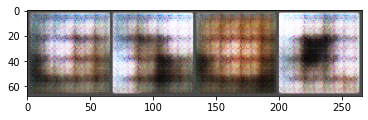

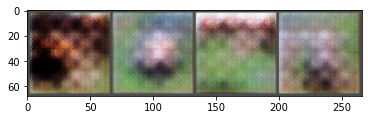

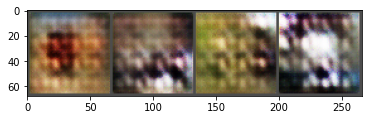

In [21]:
G = Generator(128)
D = Discriminator(128)
#G.weight_init(mean=0.0, std=0.02)
#D.weight_init(mean=0.0, std=0.02)
G = G.cuda()
D = D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
# Train GAN
collect_x_gen = []
train(your_train_loader)

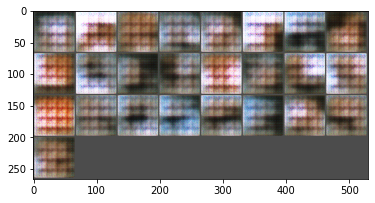

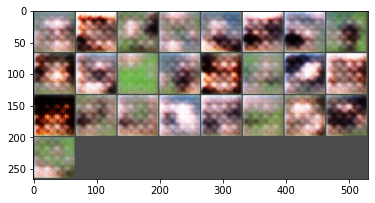

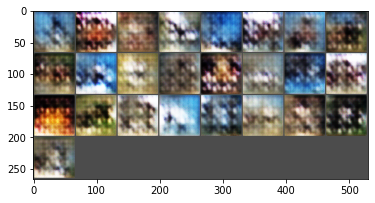

In [22]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

# A demo of a state of the art GAN and "painting" with them in your browser:

https://gandissect.csail.mit.edu

By our colleagues at the MIT-IBM Watson AI Lab.


# Where to go from here
* Use a more exciting datasets - check out [the pytorch torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) to get started quickly.
* The [original GAN paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets)
* The [DCGAN paper](https://arxiv.org/abs/1511.06434) which made it all work much better for images. Start from: pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
* Newer generations of loss functions measure different distances between distributions $p_{data}$ and $p_G$. For example [WGAN](https://github.com/martinarjovsky/WassersteinGAN), [WGAN-GP](https://arxiv.org/abs/1704.00028), [Fisher GAN](https://arxiv.org/abs/1705.09675), [Sobolev GAN](https://arxiv.org/abs/1711.04894), many more. They often have better stability properties wrt the original GAN loss.

# References for this tutorial
* pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich
* [Medium blog post](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f) by Diego Gomez Mosquera
* [Material made for ITDS course at CUNY](https://github.com/grantmlong/itds2019/blob/master/lecture-6/DL_lab_solutions.ipynb) by Tom Sercu (that's me!)
* [Blog post](https://towardsdatascience.com/graduating-in-gans-going-from-understanding-generative-adversarial-networks-to-running-your-own-39804c283399) by Cecelia Shao
* [GAN overview image](https://www.slideshare.net/xavigiro/deep-learning-for-computer-vision-generative-models-and-adversarial-training-upc-2016) from Xavier Giro